# Contex

Una empresa financiera tiene un nuevo producto dirigido a sus clientes con diferentes límites de crédito, por ello, es necesario dividir a los clientes en grupos más pequeños.

Desafortunadamente, los directivos no tienen idea de cuál es la cantidad óptima en la que se puede segregar a los clientes y cómo dirigir a nuevos clientes a esos grupos.

Es por eso que en este punto se te ha contratado. Para poder ejecutar tu trabajo te han compartido una base de datos que contiene las características que, según sus informes, son los más importantes para la aplicación de este programa. Consiste en seis puntos:
- **Salario mensual:** indica el ingreso mensual del cliente en pesos mexicanos.
- **Crédito tipo 1:** es un producto financiero que el cliente ha obtenido de la institución financiera; `1` significa que tiene este producto y `0` que no cuenta con él.
- **Crédito tipo 2:** es similar a las características del anterior; `1` significa que cuenta con el producto y `0` que no.
- **Límite de TC:** indica el límite de crédito de la tarjeta del cliente.
- **Años siendo cliente:** corresponde al tiempo que el cliente ha tenido una relación comercial con la institución financiera.
- **Previamente se ofreció el producto:** es la versión previa del producto e indica si el cliente se mostró interesado en obtenerlo (`1`) o no (`0`).

El archivo puede ser descargado aquí: https://drive.google.com/file/d/1wcjPCZPTMuDlyWcE1Do4-yqU5AglW_p9/view?usp=sharing



## Import Libraries

In [1]:
from pandas import read_csv, DataFrame

In [2]:
from numpy import where, arange, cumsum

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import (KMeans,
                             AgglomerativeClustering,
                             DBSCAN,
)
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score,
)

In [4]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from seaborn import (boxplot,
                     distplot,
                     set_style,
                     displot,
                     countplot,
                     scatterplot,
                     barplot,
                     lmplot,
                     heatmap,
)

In [6]:
import scipy.cluster.hierarchy as shc

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
!pip install kneed
from kneed import KneeLocator

## Load Data

In [10]:
df = read_csv('/content/drive/MyDrive/Colab Notebooks/proyectos/costumers.csv')
display(df.head())

,Salario,Credito_tipo_1,Credito_tipo_2,Limite_TC,Tiempo_cliente,Producto_ofrecido
0,22572.91,1,0,30136.74,0.0,1
1,10609.64,1,1,53623.94,0.0,1
2,10079.48,0,1,18135.44,0.0,0
3,13871.35,1,0,30831.75,0.0,1
4,6541.46,0,1,20626.23,0.0,0


Definimos nuestro DataFrame como *df* y observamos las primeras cinco muestras

## EDA

In [11]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Salario,500.0,12089.09738,5123.700116,-2911.65,8534.350,11438.600,15171.4675,30041.40
Credito_tipo_1,500.0,0.61000,0.488238,0.00,0.000,1.000,1.0000,1.00
Credito_tipo_2,500.0,0.45800,0.498732,0.00,0.000,0.000,1.0000,1.00
Limite_TC,500.0,44784.55496,22150.923996,-22207.95,30096.285,47991.515,59108.1750,118636.82
Tiempo_cliente,500.0,4.32700,4.784776,0.00,0.000,0.000,8.4000,19.30
Producto_ofrecido,500.0,0.60200,0.489976,0.00,0.000,1.000,1.0000,1.00


Observemos las estadisticas descritivas de nuestro dataset, podemos observar que las columnas *Salario* y *Limite_TC* sus valores minimos son negativos, lo cual no tiene sentido.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Salario            500 non-null    float64
 1   Credito_tipo_1     500 non-null    int64  
 2   Credito_tipo_2     500 non-null    int64  
 3   Limite_TC          500 non-null    float64
 4   Tiempo_cliente     500 non-null    float64
 5   Producto_ofrecido  500 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 23.6 KB


Aca mostramos la información general de nuestro dataset, desde el total de muestras hasta el tipo de dato.

In [13]:
df.isnull().sum()

Salario              0
Credito_tipo_1       0
Credito_tipo_2       0
Limite_TC            0
Tiempo_cliente       0
Producto_ofrecido    0
dtype: int64

Mostramos la completitud de nuestro dataset, en este caso no contiene valores faltantes.

### Comprobamos valores atípicos

In [14]:
fig = px.box(df, y="Salario", points="all", width=700, height=550)
fig.show()

In [15]:
fig = px.box(df, y="Limite_TC", points="all", width=700, height=550)
fig.show()

Mediante las graficas de cajas se pueden observar numerosos valores atípicos en ambas columnas.
Tambien se observan valores negativos en las columnas que no tienen sentido, por ejemplo un salario **negativo**

In [16]:
arg_min_sal = df.iloc[df['Salario'].argmin()]# Localizamos y mostramos los valores mínimos
arg_min_limt = df.iloc[df['Limite_TC'].argmin()]

print(f'Los montos mínimos de Salario son \n{arg_min_sal}.\n==================================\nY del limite de credito \n{arg_min_limt}.')

Los montos mínimos de Salario son 
Salario              -2911.65
Credito_tipo_1           1.00
Credito_tipo_2           1.00
Limite_TC            86358.80
Tiempo_cliente           0.00
Producto_ofrecido        1.00
Name: 472, dtype: float64.
Y del limite de credito 
Salario              29868.76
Credito_tipo_1           0.00
Credito_tipo_2           0.00
Limite_TC           -22207.95
Tiempo_cliente           0.00
Producto_ofrecido        1.00
Name: 478, dtype: float64.


Al igual que la columna de limite de credito, cuenta con un limite negativo

In [17]:
# Definir límites inferior y superior
qs = df.quantile([0.25,0.5,0.75]).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]

iqr = q3-q1
iqr_lim_inf = q1 - 1.285*iqr# Modifique el limite inferior de manera que me diera el monto positivo mas cercano a 1


Definimos variables con los rangos intercuartilicos, y estructuramos los limites inferiores, que son los que usaremos

In [18]:
# Y realizar el recorte en este caso a salario y graficamos de nuevo
df['Salario'] = where(df['Salario']<iqr_lim_inf,
                                 iqr_lim_inf, df['Salario'])

fig = px.box(df, y='Salario', points='all', width = 700, height=500)
fig.show()

In [19]:
# Y realizar el recorte a la columna de limite de credito, y ahora se ve así
df['Limite_TC'] = where(df['Limite_TC']<iqr_lim_inf,
                                 iqr_lim_inf, df['Limite_TC'])

fig = px.box(df, y='Limite_TC', points='all', width = 700, height=500)
fig.show()

In [20]:
arg_min_sal = df.iloc[df['Salario'].argmin()]
arg_min_limt = df.iloc[df['Limite_TC'].argmin()]

print(f'Los montos mas bajos de Salario son \n{arg_min_sal}.\n==================================\nY del limite de credito \n{arg_min_limt}.')

Los montos mas bajos de Salario son 
Salario                  5.654013
Credito_tipo_1           1.000000
Credito_tipo_2           1.000000
Limite_TC            86358.800000
Tiempo_cliente           0.000000
Producto_ofrecido        1.000000
Name: 472, dtype: float64.
Y del limite de credito 
Salario              24295.710000
Credito_tipo_1           1.000000
Credito_tipo_2           0.000000
Limite_TC                5.654013
Tiempo_cliente           0.000000
Producto_ofrecido        0.000000
Name: 47, dtype: float64.


Ahora las columnas tienen mas sentido, con valores positivos.

## Univariate analysis

In [21]:
df.columns

Index(['Salario', 'Credito_tipo_1', 'Credito_tipo_2', 'Limite_TC',
       'Tiempo_cliente', 'Producto_ofrecido'],
      dtype='object')

### *Salario colum*

<Figure size 800x600 with 0 Axes>

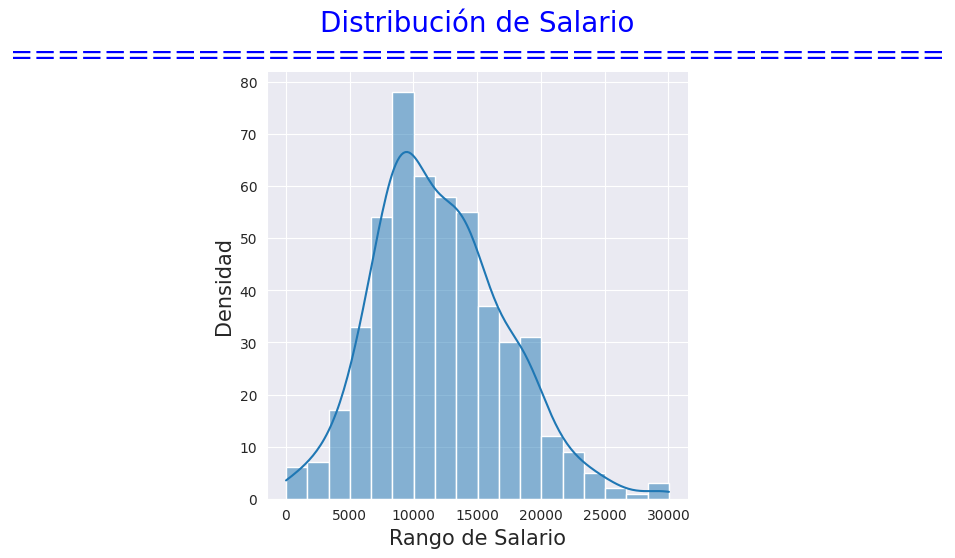

In [22]:
plt.figure(figsize=(8,6))
set_style('darkgrid')

displot(df, x="Salario", kde=True)
plt.title("Distribución de Salario\n========================================", fontsize=20, color="blue")
plt.xlabel("Rango de Salario", fontsize=15)
plt.ylabel("Densidad", fontsize=15)

plt.show()

La mayor parte de los salarios se encuentran entre los 8.000 y 15.000

### *Credito tipo 1*

In [23]:
df['Credito_tipo_1'].unique()

array([1, 0])

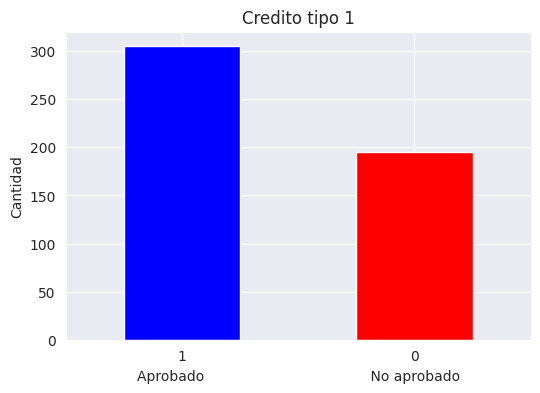

In [24]:
plt.figure(figsize=(6,4))
df['Credito_tipo_1'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Aprobado                                      No aprobado')
plt.ylabel('Cantidad')
plt.title('Credito tipo 1')
plt.xticks(rotation=0)
plt.show()

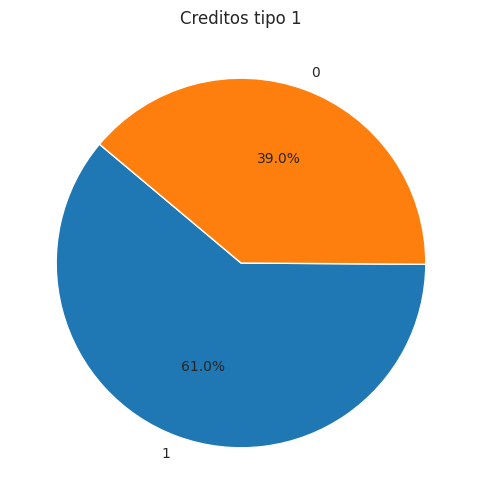

In [25]:
plt.figure(figsize=(6,6))
df['Credito_tipo_1'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Creditos tipo 1')
plt.ylabel('')
plt.show()

Podemos observar que tiene mayor tasa de aprobación credito tipo 1.

### *Credito tipo 2*

In [26]:
df['Credito_tipo_2'].nunique()

2

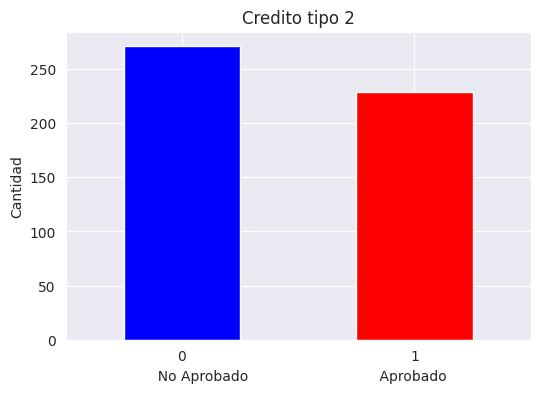

In [27]:
plt.figure(figsize=(6,4))
df['Credito_tipo_2'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel('  No Aprobado                              Aprobado')
plt.ylabel('Cantidad')
plt.title('Credito tipo 2')
plt.xticks(rotation=0)
plt.show()

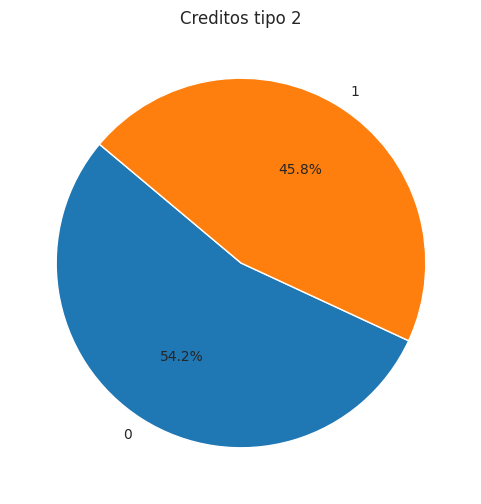

In [28]:
plt.figure(figsize=(6,6))
df['Credito_tipo_2'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Creditos tipo 2')
plt.ylabel('')
plt.show()

A diferencia del credito tipo 1, este credito tipo 2 su tasa de aceptación es un poco mas baja.

### *Limite_TC colum*

<Figure size 800x600 with 0 Axes>

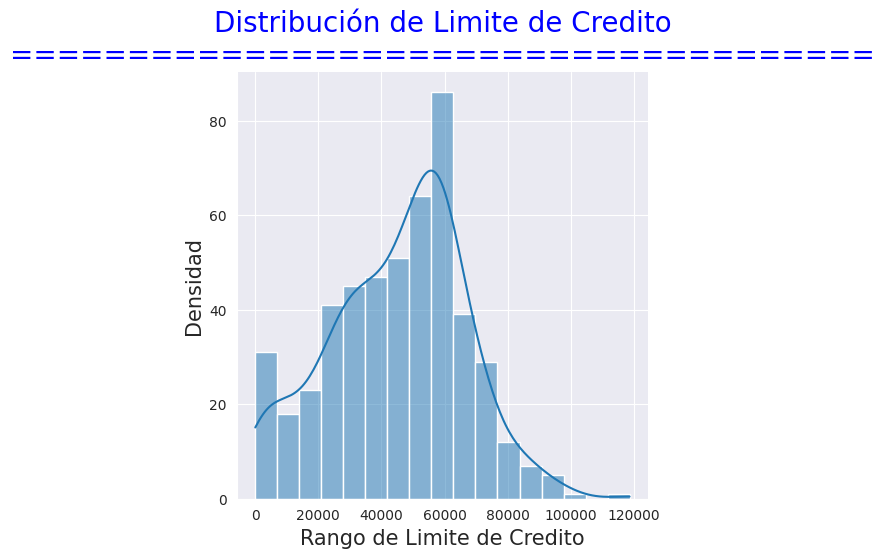

In [29]:

plt.figure(figsize=(8,6))
set_style('darkgrid')

displot(df, x="Limite_TC", kde=True)
plt.title("Distribución de Limite de Credito\n=====================================", fontsize=20, color="blue")
plt.xlabel("Rango de Limite de Credito", fontsize=15)
plt.ylabel("Densidad", fontsize=15)

plt.show()

La mayor parte del limite de credito estan entre los 45.000 y 60.000. Y hay una cantidad considerable las cuales no cuentan con credito.

### *Tiempo cliente colum*

In [30]:
df['Tiempo_cliente'].value_counts()

Tiempo_cliente
0.0     254
7.0       8
7.2       7
7.3       7
8.5       6
       ... 
15.0      1
13.1      1
7.8       1
10.6      1
15.3      1
Name: count, Length: 88, dtype: int64

<Figure size 1000x600 with 0 Axes>

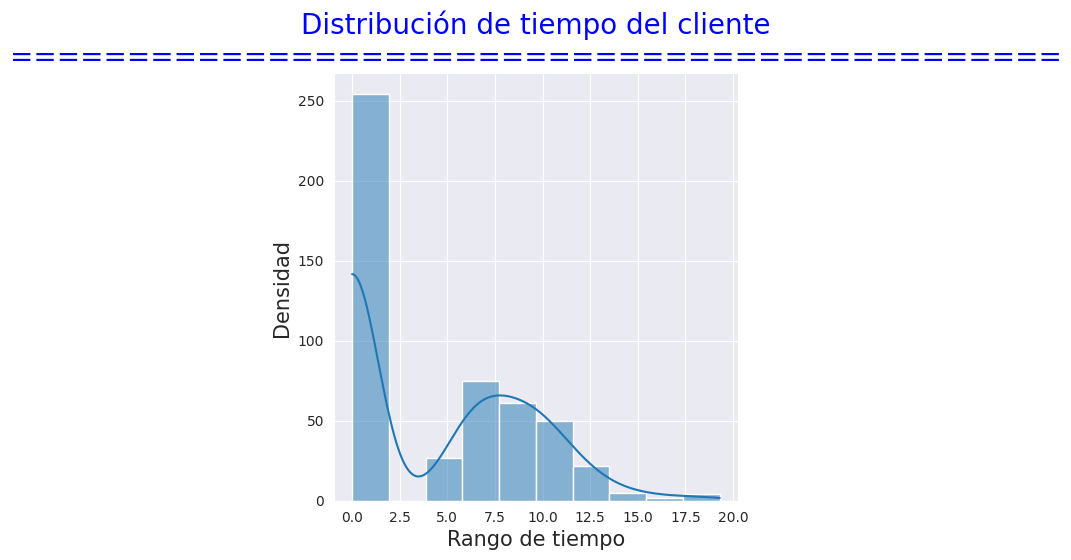

In [31]:
plt.figure(figsize=(10,6))
set_style('darkgrid')

displot(df, x="Tiempo_cliente", kde=True)
plt.title("Distribución de tiempo del cliente\n=============================================", fontsize=20, color="blue")
plt.xlabel("Rango de tiempo", fontsize=15)
plt.ylabel("Densidad", fontsize=15)

plt.show()

La distribución no esta nada pareja y fluctua de manera particual, aqui nos muestra que la gran mayoria cuentan con 0-1 año siendo cliente, luego entre los 7-11 años su segundo peack.

### *Producto ofrecido*

In [32]:
df['Producto_ofrecido'].value_counts()

Producto_ofrecido
1    301
0    199
Name: count, dtype: int64

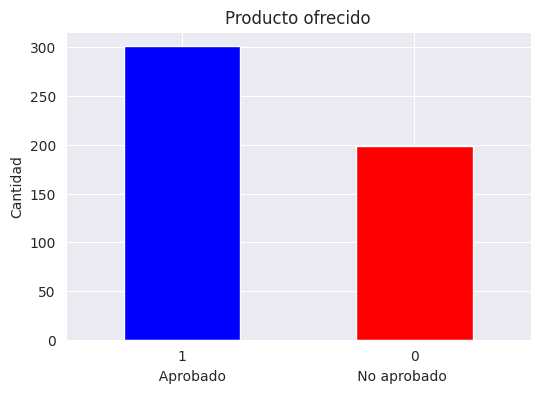

In [33]:
plt.figure(figsize=(6,4))
df['Producto_ofrecido'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel('  Aprobado                              No aprobado')
plt.ylabel('Cantidad')
plt.title('Producto ofrecido')
plt.xticks(rotation=0)
plt.show()

En su mayoria se cuenta con clientes con el producto ofrecido.

## Analisis bivariado

In [34]:
df.columns

Index(['Salario', 'Credito_tipo_1', 'Credito_tipo_2', 'Limite_TC',
       'Tiempo_cliente', 'Producto_ofrecido'],
      dtype='object')

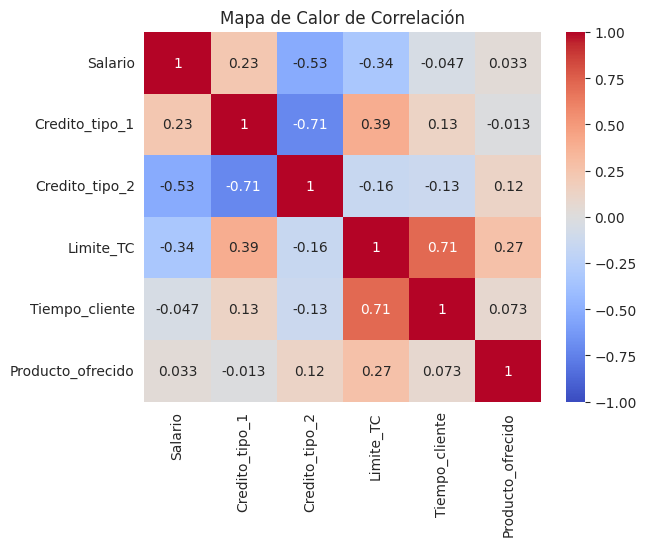

In [35]:
corr = df.corr()
heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlación')
plt.show()

Acá podemos observar un mapa de calor con la correlación de nuestras features, logramos ver la mayor relacion que seria *Limite_TC* con *Tiempo_cliente*, nos indica que mientras mas tiempo se este en el banco en este caso, incrementa el limite crediticio; seguido con *Credito_tipo_1* y por ultimo con *Producto_ofrecido*, nos indica que mientras mas tiempo siendo cliente, la tasa de aceptación de producto incrementa.

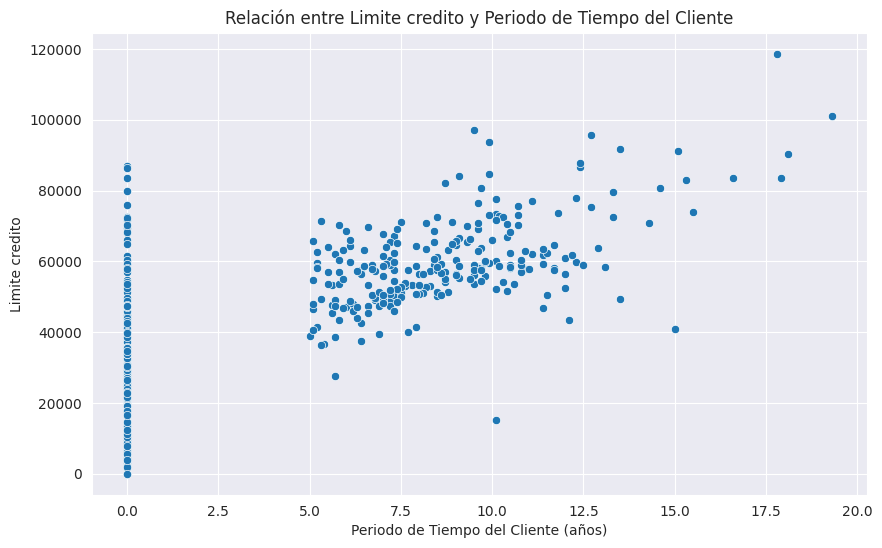

In [38]:
plt.figure(figsize=(10, 6))
scatterplot(data=df, x='Tiempo_cliente', y='Limite_TC', marker='o')

# Añadir títulos y etiquetas
plt.title('Relación entre Limite credito y Periodo de Tiempo del Cliente')
plt.xlabel('Periodo de Tiempo del Cliente (años)')
plt.ylabel('Limite credito')
plt.grid(True)

hay una concentración significativa de puntos a la izquierda del eje X (en el periodo de tiempo cercano a 0), indicando que hay muchos clientes con un periodo de tiempo muy corto.

Se observa una tendencia ligera de incremento en el límite de crédito a medida que aumenta el periodo de tiempo del cliente. Los clientes que han estado más tiempo tienden a tener límites de crédito más altos.

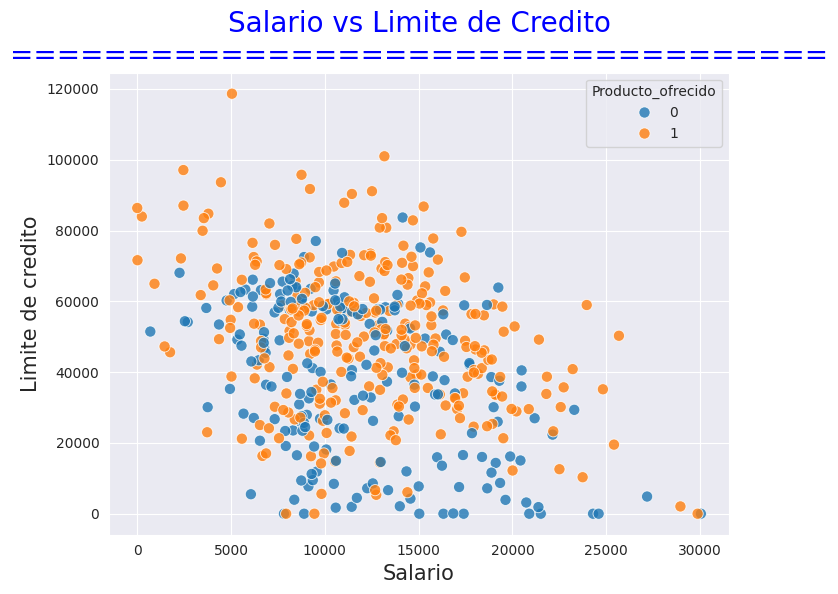

In [ ]:
plt.figure(figsize=(8,6))
set_style('darkgrid')
scatterplot(data=df, x="Salario", y= "Limite_TC", hue="Producto_ofrecido", s=65, alpha= 0.8)
plt.title("Salario vs Limite de Credito\n===================================", fontsize=20, color="blue")
plt.xlabel("Salario", fontsize=15)
plt.ylabel("Limite de credito", fontsize=15)
plt.show()

Aplicamos una grafica de dispersión con los features *Salario* y *Limite de credito*, con el parametro de *producto ofrecido* para ver su comportamiento. Podemos ver que los que las personas con mayor limite de credito tienden a tener el producto ofrecido, mientras que las personas con menos limite tienden a no poseerlo.

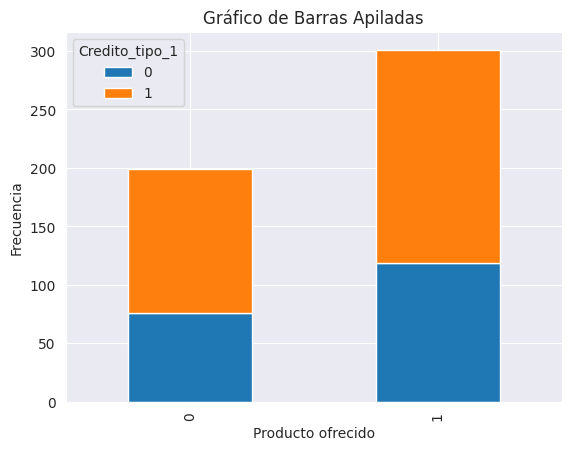

In [ ]:
df.groupby(['Producto_ofrecido', 'Credito_tipo_1']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Producto ofrecido')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras Apiladas')
plt.show()

Podemos ver que los que cuentan con el *Credito tipo 1*, en su mayoria cuentan con el producto ofrecido, y en su minoria, los que no cuentan con el *Credito tipo 1*

## Data preprocessing

In [ ]:
df.head()

,Salario,Credito_tipo_1,Credito_tipo_2,Limite_TC,Tiempo_cliente,Producto_ofrecido
0,22572.91,1,0,30136.74,0.0,1
1,10609.64,1,1,53623.94,0.0,1
2,10079.48,0,1,18135.44,0.0,0
3,13871.35,1,0,30831.75,0.0,1
4,6541.46,0,1,20626.23,0.0,0


In [ ]:
df.drop(columns=['Credito_tipo_1', 'Credito_tipo_2'], inplace=True)

### Scaling

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

definimos el metodo de escalamiento que usaremos, en este caso Z-score, como tenemos valores atípicos que creo que son importantes, nos sera mas utíl por su robustez y eficiencia ante valores atípicos

### Elbow method

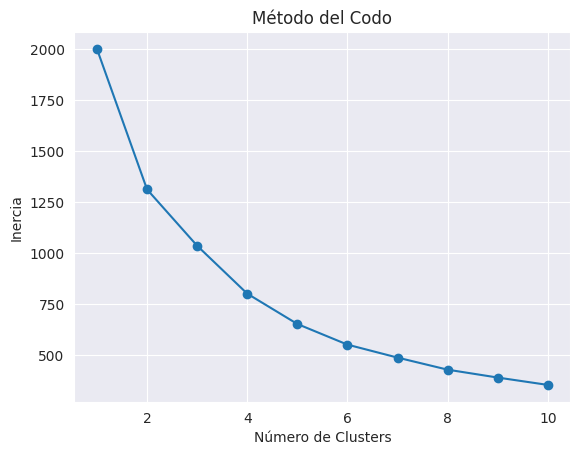

In [ ]:
inertia = [] # Lista vacía
for i in range(1, 11):# Bucle for en rango de 1 a 10 para instanciar en cada valor, luego guardar resultados en lista vacía
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()


Aplicaremos metodo del codo para buscar el valor optimo de K mediante la inercía, se toma el valor en el cual la grafica se inclina mas, en este caso usaremos *K=4*

### Knee method

In [ ]:
kneedle = KneeLocator(range(1,11), inertia, curve='convex', direction='decreasing')
elbow_point =  kneedle.elbow
print(elbow_point)

4


Como segunda opción usaremos el metodo de 'rodilla' que igualmente hace uso de la inercia y así arrojar el valor optimo de K

### PCA

In [ ]:
#n_components = 2
pca = PCA(n_components=2)
scaled_pca = pca.fit_transform(df)
print(pca.explained_variance_ratio_)

[0.95320342 0.04679656]


Para una mejor visualización de los Cluster usaremos una reducción de dimensiones con PCA, se lo aplicaremos en nuestro dataset escalado

## KMeans cluster

In [ ]:
#K = 4
kmeans = KMeans(n_clusters=4,
                random_state=40).fit(scaled_pca)

df_pca = DataFrame(scaled_pca, columns=['PCA1', 'PCA2'])
df['Cluster'] = kmeans.labels_
df_pca['Cluster'] = kmeans.labels_

Instanciamos y ajustamos nuestro metodo de clustering, en este caso KMeans, y usaremos el valor optimo K=4 que nos arrojo los metodos anteriores, luego creamos un dataframe que contendra los componentes principales, y visualizarlo de manera mas facíl, agregando una columna de las agrupaciones(cluster)

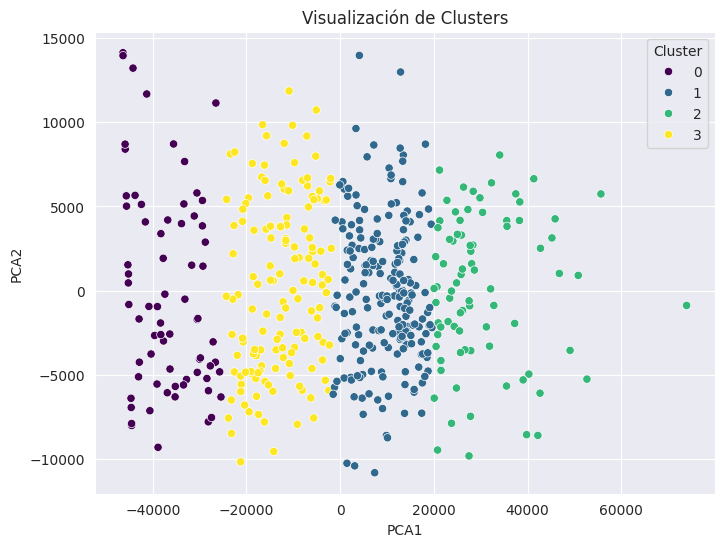

In [ ]:
plt.figure(figsize=(8, 6))
scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('Visualización de Clusters')
plt.show()

Creamos un *dataframe* que contenga los dos componentes principales y la columna de Cluster creada con KMeans, para observar como se comporta y sus agrupaciones

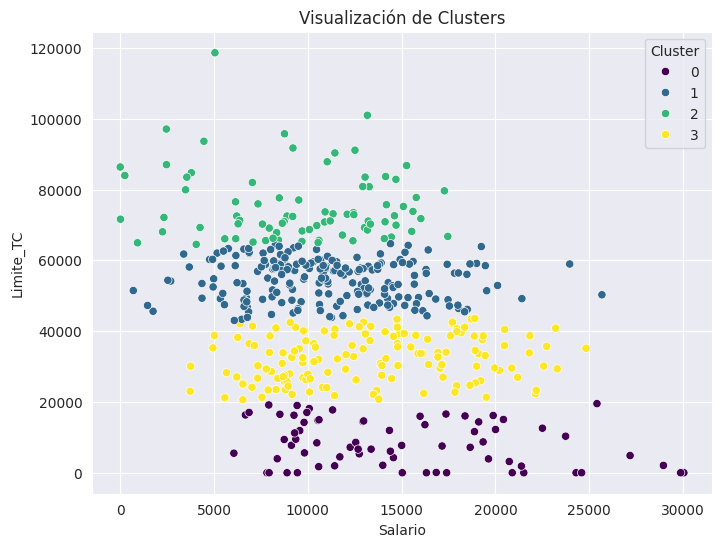

In [ ]:
plt.figure(figsize=(8, 6))
scatterplot(x='Salario', y='Limite_TC', hue='Cluster', data=df, palette='viridis')
plt.title('Visualización de Clusters')
plt.show()

Usamos la misma grafica anterior, con la diferencia que la aplicamos al *dataframe* original escalado, podemos ver que cambian las agrupaciones

## Agglomerative Clustering

In [ ]:
# Aplicar Agglomerative Clustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=4,
                                                   affinity='euclidean',
                                                   linkage='ward')

df['Cluster'] = agglomerative_clustering.labels_
scaled_pca['Cluster'] = agglomerative_clustering.labels_


Para tener una idea diferente usaremos otra tecnica de clustering, en este caso usaremos *Agglomerative clustering*

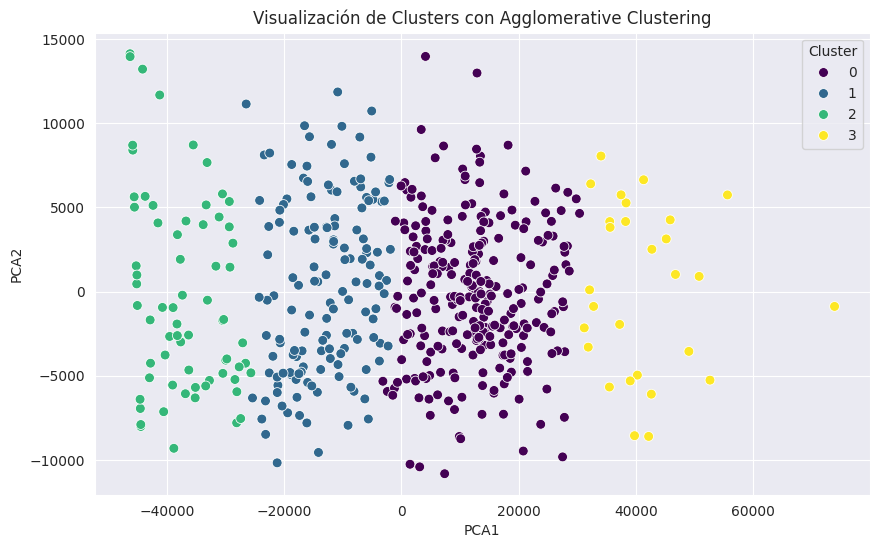

In [ ]:
plt.figure(figsize=(8, 6))
scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('Visualización de Clusters con Agglomerative Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Aplicamos una grafica de dispersión, en este caso al *dataframe* con los componentes principales.

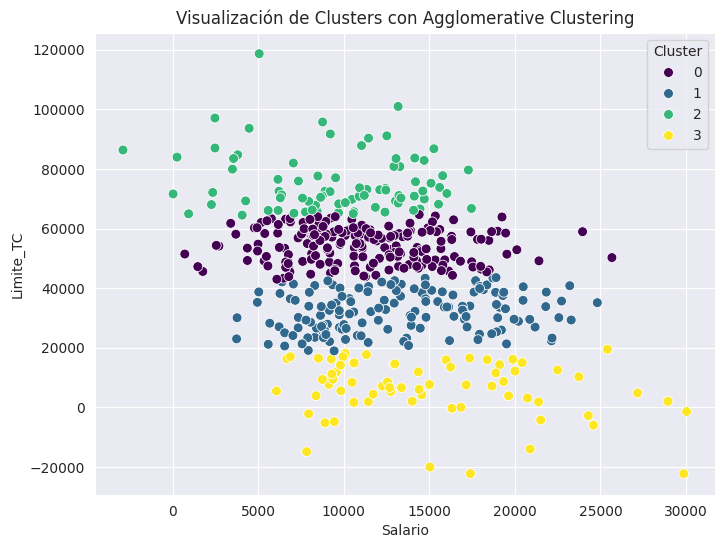

In [ ]:
plt.figure(figsize=(8, 6))
scatterplot(data=df, x='Salario', y='Limite_TC', hue='Cluster', palette='viridis', s=50)
plt.title('Visualización de Clusters con Agglomerative Clustering')
plt.xlabel('Salario')
plt.ylabel('Limite_TC')
plt.legend(title='Cluster')
plt.show()

Y al igual que las graficas anteriores, acá se la aplcamos al *dataframe* original con las muestras escaladas.

## Aplicación de metricas de desempeño

In [ ]:
silhouette_avg = silhouette_score(df, df['Cluster'])
db_score = davies_bouldin_score(df, df['Cluster'])
ch_score = calinski_harabasz_score(df, df['Cluster'])
print(f'Índice de Silueta: {silhouette_avg}')
print(f'El coeficiente del índice Calinski-Harabasz es de {ch_score}.')
print(f'El coeficiente del índice Davies-Bouldin es de {db_score}.')

Índice de Silueta: 0.45615259890267384
El coeficiente del índice Calinski-Harabasz es de 943.0221360184264.
El coeficiente del índice Davies-Bouldin es de 0.7033885733580293.


- Un valor de silueta más cercano a 1 indica un mejor rendimiento
- Con la metrica davies_bouldin un valor más alto es mejor
- La metrrica de calinski nos dice que un valor más bajo es mejor

# Conclusion

Como pudimos observar en el desarrollo de este pequeño proyecto, estabamos trabajando con un dataset bastante pequeño en el cual eran muetras bancarias; hicimos un analisis exploratorio de datos los cuales nos arrojo insights interesantes:
- Pudimos descubrir errores en la calidad de los datos, ya que habian salarios y limite de credito con valores negativos
- Los años siendo cliente tienen importancia, ya que mientras mas tiempo formes parte siendo cliente tu limite de credito sera mas alto
- El salario no juega un papel tan importante, ya que no tienen mucha relación el salario con otras caracteristicas, influye más el tiempo de clientes.
- Por no contar con un dataset con mas muestras no se pudo conseguir un buen desempeño con nuestros modelos de *modelado no supervisado*
- Mediante el desarrollo de nuestro modelo pudimos encontrar el numero optimo de segmentación, en este caso fue de 4*
- En este caso pudimos emplear dos tecnicas diferentes para agrupar las muestras, pudimos observar aquellos clientes que cuentan con un salario muy alto no cuentan limite de credito tan altos, por otra parte, aquellos clientes con sueldos bajos-moderados cuentan con un limite de credito mucho mas alto.